# Импорт библиотек

In [437]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time
from imblearn.over_sampling import SMOTENC
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [438]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Датасет содержит данные о 5110 людях, часть из которых перенесла инсульт. Для каждого из них имеются следующие данные:
* Пол
* Возраст
* Наличие гипертензии
* Наличие проблем с сердцем
* Брак в прошлом или настоящем
* Тип работы
* Местность проживания
* Средний уровень сахара в крови
* Индекс массы тела
* Данные о курении
Последний столбец - отклик (наличие перенесенного инсульта). Большая часть признаков - категориальные, притом бинарные или тернарные.

In [439]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

# Подготовка данных

## Пустые значения

Проверим строки на пустые значения.

In [440]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Единственный столбец с пустыми значениями - ИМТ. Для исследования здоровья это довольно важный признак, тем более пустые значения составляют всего 4% от общего числа строк. Таким образом, нет смысла избавляться от столбца целиком.

При этом, нет очевидного способа заменить пропущенные значения, поэтому просто избавимся от них.



In [441]:
df.dropna(inplace=True)

## Выбросы

Столбец id можно убрать из рассмотрения, т.к. он не несет в себе никакой значимой информации. Для числовых столбцов выведем основные статистические показатели, а также построим гистограммы.

In [442]:
df.drop('id', axis=1, inplace=True)
df.drop(['hypertension', 'heart_disease', 'stroke'], axis=1).describe()

,age,avg_glucose_level,bmi
count,4909.000000,4909.000000,4909.000000
mean,42.865374,105.305150,28.893237
std,22.555115,44.424341,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.070000,23.500000
50%,44.000000,91.680000,28.100000
75%,60.000000,113.570000,33.100000
max,82.000000,271.740000,97.600000


<Axes: xlabel='bmi', ylabel='Count'>

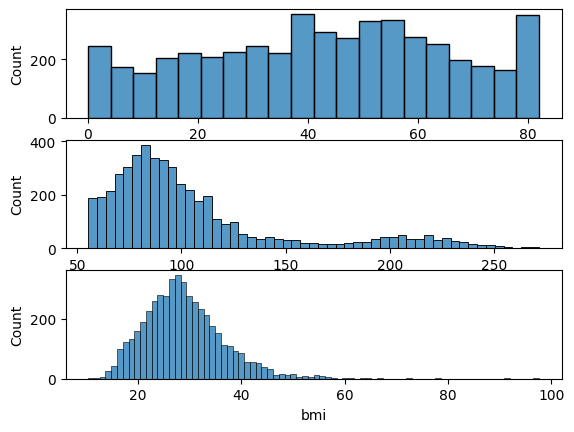

In [443]:
fig, axes = plt.subplots(3, 1)
sns.histplot(df.age, ax=axes[0])
sns.histplot(df.avg_glucose_level, ax=axes[1])
sns.histplot(df.bmi, ax=axes[2])

Видно, что в данных об уровне сахара в крови и ИМТ есть выбросы. Вычислим z-score значений данных столбцов.

In [444]:
z_glucose = zscore(df.avg_glucose_level.sort_values())
z_glucose

4886   -1.129792
1191   -1.127541
4110   -1.127316
682    -1.126865
772    -1.126640
          ...   
2462    3.630921
4983    3.653659
3088    3.653884
1207    3.657261
193     3.746860
Name: avg_glucose_level, Length: 4909, dtype: float64

In [445]:
z_bmi = zscore(df.bmi.sort_values())
z_bmi

1609   -2.367580
3307   -2.240244
2187   -2.214777
657    -2.151110
922    -2.112909
          ...   
1559    4.826878
544     5.476290
928     6.253036
4209    8.035734
2128    8.748813
Name: bmi, Length: 4909, dtype: float64

По правилу трех сигм, мы можем избавиться от измерений с Z-score больше 3 по модулю без значительных потерь - даже при таком условии мы сохраним более 99.7% данных.

In [446]:
df_cleaned = df[(zscore(df.bmi) <= 3) & (zscore(df.avg_glucose_level) <= 3)]
df_cleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Категориальные признаки и балансировка классов

Теперь рассмотрим категориальные признаки. Взглянем на уникальные значения каждого столбца.

In [447]:
df_cleaned.drop(['age', 'avg_glucose_level', 'bmi'], axis=1).nunique()

gender            3
hypertension      2
heart_disease     2
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
stroke            2
dtype: int64

In [448]:
for col in df_cleaned.drop(['age', 'avg_glucose_level', 'bmi'], axis=1):
    print(df_cleaned[col].unique())

['Male' 'Female' 'Other']
[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
[1 0]


В столбце с данными о курении есть аналог пустого значения - Unknown, вычислим его долю во всем датасете.

In [449]:
len(df_cleaned[df.smoking_status == 'Unknown']) / len(df_cleaned)

0.3057178631051753

Измерения с неизвестной информации о курении составляют почти треть от всех данных, поэтому просто избавиться от строк не получится. Посмотрим на долю классов среди данных строк, чтобы понять значимость признака и увидеть, можно ли заменить его на иное значение.

In [450]:
df_cleaned[df.smoking_status == 'Unknown']['stroke'].value_counts()

stroke
0    1436
1      29
Name: count, dtype: int64

In [451]:
29/1436

0.0201949860724234

In [452]:
df_cleaned[df.smoking_status == 'never smoked']['stroke'].value_counts()

stroke
0    1724
1      78
Name: count, dtype: int64

In [453]:
78/1724

0.04524361948955916

Видно, что большая часть людей среди данных строк не имеет перенесенного инсульта. Действуя из предположения негативного влияния курения на здоровье мозговых сосудов, заменим все строки Unknown на Never smoked, поскольку среди всех остальных значений столбца smoking_status строки с таким значением имеют самое похожее распределение откликов.

In [454]:
df_cleaned[['smoking_status']] = df_cleaned[['smoking_status']].replace('Unknown', 'never smoked')
df_cleaned.smoking_status.unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

Перед тем, как провести финальное преобразование - one-hot encoding, проверим сбалансированность классов, чтобы при необходимости сделать апсемплинг при помощи SMOTENC.

In [455]:
df_cleaned.stroke.value_counts()

stroke
0    4596
1     196
Name: count, dtype: int64

Виден дисбаланс в сторону класса 1. SMOTENC позволит нам выровнять количество измерений обоих классов.

In [456]:
x = df_cleaned.drop('stroke', axis=1)
y = df_cleaned.stroke
sm = SMOTENC(categorical_features=[0,2,3,4,5,6,9])
x, y = sm.fit_resample(x, y)

In [457]:
y.value_counts()

stroke
1    4596
0    4596
Name: count, dtype: int64

Теперь с балансом все в порядке, проведем финальный шаг для облегчения классификации. При помощи pd.get_dummies совершим one-hot encoding, преобразуя категориальные признаки в более удобную для классификации форму.

In [458]:
x_dummies = pd.get_dummies(x, drop_first=True, dtype='int')
x_dummies

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
0,67.000000,0,1,228.690000,36.600000,1,0,1,0,1,0,0,1,0,0
1,80.000000,0,1,105.920000,32.500000,1,0,1,0,1,0,0,0,1,0
2,49.000000,0,0,171.230000,34.400000,0,0,1,0,1,0,0,1,0,1
3,79.000000,1,0,174.120000,24.000000,0,0,1,0,0,1,0,0,1,0
4,81.000000,0,0,186.210000,29.000000,1,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9187,78.609982,0,0,75.452028,34.159572,0,0,1,0,0,1,0,1,1,0
9188,79.000000,0,0,89.095056,22.955102,0,0,1,0,1,0,0,0,1,0
9189,47.697829,0,0,61.961503,29.737229,0,0,1,0,1,0,0,1,1,0
9190,56.290041,0,0,207.245850,38.645457,0,0,1,0,1,0,0,1,0,1


# Выбор и обучение модели

Теперь мы готовы выполнять классификацию. Разобьем датасет на предикторы и отклики, а также произведем train/test split.

In [459]:
x_train, x_test, y_train, y_test = train_test_split(x_dummies, y, test_size=0.25, stratify=y)

Было опробовано несколько простых моделей классификации, но в итоге выбор пал на ансамблевую модель - Random Forest Classifier. Протестируем модель с разным количеством деревьев и измерим ее точность и время обучения.

In [460]:
trees = [10, 50, 100, 250, 500, 750, 1000]
times = []
scores = []
for n in trees:
    rfc = RandomForestClassifier(n_estimators=n)
    start = time.time()
    rfc.fit(x_train, y_train)
    end = time.time()
    times.append(end - start)
    pred = rfc.predict(x_test)
    scores.append(f1_score(y_test, pred))

Построим графики для определения оптимального количества деревьев

<Axes: >

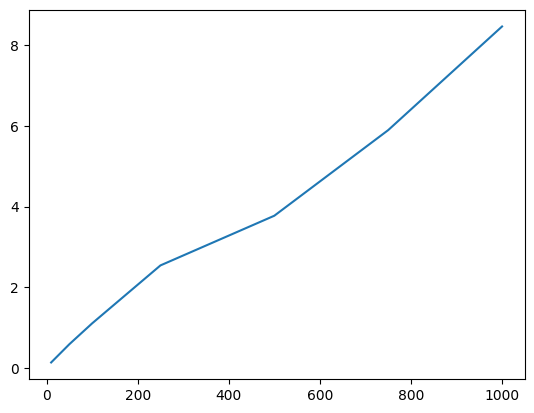

In [461]:
sns.lineplot(x=trees, y=times)

<Axes: >

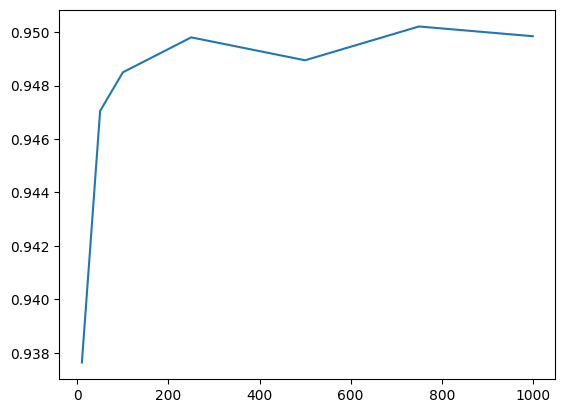

In [462]:
sns.lineplot(x=trees, y=scores)

Точность не сильно увеличивается после 250 деревьев, однако сильно растет время обучения. Для нашей модели такой точности будет более чем достаточно.

Таким образом, мы имеем обученную модель классификации для предсказания вероятного инсульта на основании нескольких признаков. Протестировав модель на себе, могу сказать, что мне инсульт не страшен ;)